# Maspawio

## Dublin Core to Schema.org workflow testing

An experiment to see if we can convert a Dublin Core record to Schema.org.  The focus will be on OIH type https://book.oceaninfohub.org/thematics/docs/README.html

The source location is: https://maspawio.net/layers/geonode%3Alocally_managed_marine_areas_kenya 

Need to generate somethnig like documented at: https://book.oceaninfohub.org/thematics/docs/maps.html   We will need to add into this a sptial geometry to scope the bounding box.

### refs

* https://maspawio.net/layers/geonode%3Alocally_managed_marine_areas_kenya 
* https://docs.google.com/spreadsheets/d/1OS_DPrPppxkWR7kU3vjRJaDSCq3XFn74/edit#gid=1139001206


In [1]:
import json
from pyld import jsonld
import os, sys, io
import xml.etree.ElementTree as ET
from urllib.request import urlopen
import ssl
import pandas as pd
import kglab

In [2]:
# Source Dubline core XML from net (https issue)
# Groups do need to start to move to https over http.  However, when doing so, the issue of geting and installing the certificate
# can be an impediment.  A popular group used by many is the Let's Encrypt group (https://letsencrypt.org/).  Reference their 
# documentation on CertBot (https://certbot.eff.org/)

# fails on SSL, cert needs updated but we can ignore it for now.

ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

dcxml = "http://maspawio.net/catalogue/csw?outputschema=http%3A%2F%2Fwww.opengis.net%2Fcat%2Fcsw%2F2.0.2&service=CSW&request=GetRecordById&version=2.0.2&elementsetname=full&id=3046b5fc-18e0-11eb-894f-0a735f7a740c"
with urlopen(dcxml, context=ctx) as f:
    tree = ET.parse(f)
    root = tree.getroot()
    
r = root.find('{http://www.opengis.net/cat/csw/2.0.2}Record')

In [3]:
# Bypassing the issue of the https cert, use a local file downloaded by bypassing the warning. 
# tree = ET.parse('./data/dublin.xml')
# root = tree.getroot()
# print(root.tag)

In [4]:
# Just a loop to inspect all the elements, normall commented out and not needed in final script
# for element in r.findall('*'):
#             print("{} :: {}".format(element.tag, element.text))

# Type matching

In this case we see the type as "dataset" so we can match this to schema.org/Dataset.  Other types would need special 
paths.  

In [5]:
# id
id = r.find('{http://purl.org/dc/elements/1.1/}identifier')
print(id.text)

# name
# This can be used to form the URL:  https://maspawio.net/layers/geonode%3Alocally_managed_marine_areas_kenya
name = r.find('{http://purl.org/dc/elements/1.1/}title')
print(name.text)

# description
description = r.find('{http://purl.org/dc/terms/}abstract')
print(description.text)

# keywords
subjects = r.findall('{http://purl.org/dc/elements/1.1/}subject')
for s in subjects:
    print(s.text)

# spatial data
bb = r.find('{http://www.opengis.net/ows}BoundingBox')
uc = bb.find('{http://www.opengis.net/ows}UpperCorner')
lc = bb.find('{http://www.opengis.net/ows}LowerCorner')
ucs = uc.text.split(" ")
lcs = lc.text.split(" ")
x1 = float(ucs[0])
y1 = float(ucs[1])
x2 = float(lcs[0])
y2 = float(lcs[1])

# # 'POLYGON(x1 y1, x1 y2, x2 y2, x2 y1, x1 y1)'
poly = str("""POLYGON({}  {}  {}  {} {}  {}  {}  {} {} {})""".format(x1, y1, x1, y2, x2, y2, x2, y1, x1, y1))

print(poly)

# url https://maspawio.net/layers/geonode:locally_managed_marine_areas_kenya

3046b5fc-18e0-11eb-894f-0a735f7a740c
locally managed marine areas Kenya
This resource/layer shows the spatial location of locally managed marine areas (LMMA) along the Kenyan coast. The information comes from a report done by CORDIO in 2015 that sought to review a detailed history of LMMA development in Kenya. For more information, please contact jkawaka@cordioea.net


kenya
LMMA
POLYGON(-2.094547  41.116223  -2.094547  39.235491 -4.674234  39.235491  -4.674234  41.116223 -2.094547 41.116223)


In [6]:
data = {}

data['@id'] = str("https://maspawio.net/id/{}".format(id.text))      #id.text
data['@type'] = 'https://schema.org/Dataset'

data['https://schema.org/name'] = name.text
data['https://schema.org/description'] = description.text

aswkt = {}
aswkt['@type'] = "http://www.opengis.net/ont/geosparql#wktLiteral"
aswkt['@value'] = poly

crs = {}
crs['@id'] = "http://www.opengis.net/def/crs/OGC/1.3/CRS84"

hg = {}
hg['@type'] = "http://www.opengis.net/ont/sf#Polygon" 
hg['http://www.opengis.net/ont/geosparql#asWKT'] = aswkt
hg['http://www.opengis.net/ont/geosparql#crs'] = crs

data['http://www.opengis.net/ont/geosparql#hasGeometry'] = hg

# keyword(s) loop
k = []
for s in subjects:
    k.append(s.text)
data['https://schema.org/keywords'] = k 

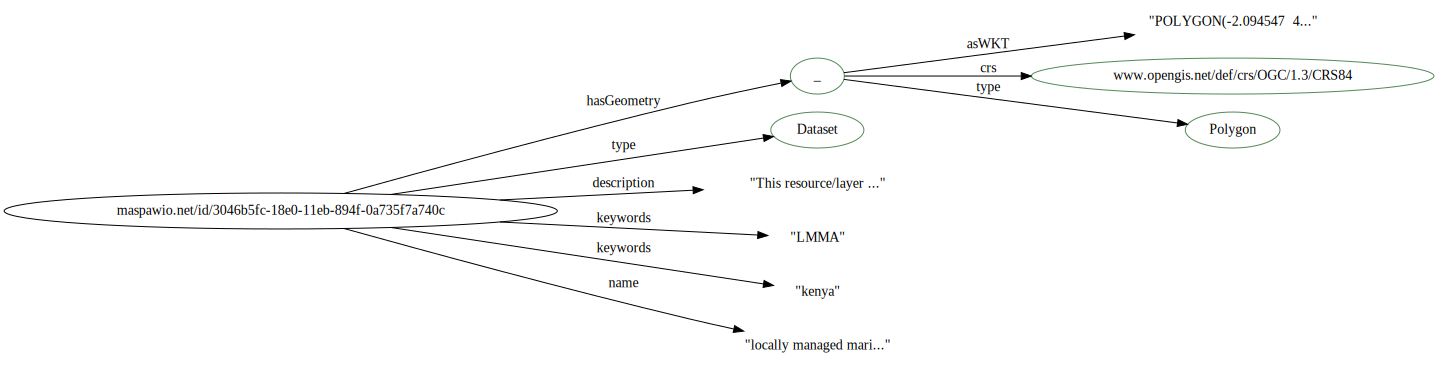

In [7]:
currentdir = os.path.dirname(os.path.abspath(''))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, currentdir)
from lib import jbutils

context = {"@vocab": "https://schema.org/", "geosparql": "http://www.opengis.net/ont/geosparql#"}
compacted = jsonld.compact(data, context)

jbutils.show_graph(compacted)

In [8]:
# jd = json.dumps(compacted, indent=4)
# print(jd)

with open('data/maspawio.json', 'w', encoding='utf-8') as f:
    json.dump(compacted, f, ensure_ascii=False, indent=4)

In [9]:
import kglab

namespaces = {
    "schema":  "https://schema.org/",
    "shacl":   "http://www.w3.org/ns/shacl#" ,
    }

kg = kglab.KnowledgeGraph(
    name = "Schema.org based datagraph",
    base_uri = "https://example.org/id/",
    namespaces = namespaces,
    )



In [10]:
# f = io.BytesIO(str.encode(jd))
kg.load_jsonld("./data/maspawio.json")

In [11]:
# export the graph
kg.save_rdf("./data/maspawioSingle.ttl", format="ttl", base=None, encoding="utf-8")

In [12]:
links = pd.read_csv("./data/maspawio.csv", skiprows=7)

In [13]:
links.head()

,Resource name,Data type,Coverage,Designation,Link address,dclink
0,locally managed marine areas Kenya,Point vector,National,Kenya,https://maspawio.net/layers/geonode%3Alocally_...,http://maspawio.net/catalogue/csw?outputschema...
1,Sea Level Rise vulnearbility,Raster data,Sub-national,Kenya-Mombasa drfils@gmail.com,https://maspawio.net/layers/geonode%3Akwale_ki...,http://maspawio.net/catalogue/csw?outputschema...
2,kwale Marine depth contours,Vector lines,Sub-national,Kenya-Kwale,https://maspawio.net/layers/geonode%3Akwale_ma...,http://maspawio.net/catalogue/csw?outputschema...
3,kwale bathymetry,Raster data,Sub-national,Kenya-Kwale,https://maspawio.net/layers/geonode%3Akwale_ba...,http://maspawio.net/catalogue/csw?outputschema...
4,Fishing intensity Kipini,Raster data,Sub-national,Kenya-Tana River,https://maspawio.net/layers/geonode%3Akipini_f...,http://maspawio.net/catalogue/csw?outputschema...


In [14]:
linkcol = links["dclink"]
urls = linkcol.values

In [15]:
namespaces = {
    "schema":  "https://schema.org/",
    "shacl":   "http://www.w3.org/ns/shacl#" ,
    }

kgset = kglab.KnowledgeGraph(
    name = "Schema.org based datagraph",
    base_uri = "https://example.org/id/",
    namespaces = namespaces,
    )

In [16]:
index = 0

for x in urls:
    index = index +1 
    
    dcxml = x
    with urlopen(dcxml, context=ctx) as f:
        tree = ET.parse(f)
        root = tree.getroot()
        
    r = root.find('{http://www.opengis.net/cat/csw/2.0.2}Record')

    # id
    id = r.find('{http://purl.org/dc/elements/1.1/}identifier')

    # name
    # This can be used to form the URL:  https://maspawio.net/layers/geonode%3Alocally_managed_marine_areas_kenya
    name = r.find('{http://purl.org/dc/elements/1.1/}title')

    # description
    description = r.find('{http://purl.org/dc/terms/}abstract')

    # keywords
    subjects = r.findall('{http://purl.org/dc/elements/1.1/}subject')

    # spatial data
    bb = r.find('{http://www.opengis.net/ows}BoundingBox')
    uc = bb.find('{http://www.opengis.net/ows}UpperCorner')
    lc = bb.find('{http://www.opengis.net/ows}LowerCorner')
    ucs = uc.text.split(" ")
    lcs = lc.text.split(" ")
    x1 = float(ucs[0])
    y1 = float(ucs[1])
    x2 = float(lcs[0])
    y2 = float(lcs[1])

    # # 'POLYGON(x1 y1, x1 y2, x2 y2, x2 y1, x1 y1)'
    poly = str("""POLYGON({}  {}  {}  {} {}  {}  {}  {} {} {})""".format(x1, y1, x1, y2, x2, y2, x2, y1, x1, y1))

    
    
    data = {}

#     data['@id'] = str("https://maspawio.net/id/{}".format(id.text))      #id.text
    data['@id'] = str("https://maspawio.net/id/{}".format(index))      #id.text

    data['@type'] = 'https://schema.org/Dataset'

    data['https://schema.org/name'] = name.text
    data['https://schema.org/description'] = description.text

    aswkt = {}
    aswkt['@type'] = "http://www.opengis.net/ont/geosparql#wktLiteral"
    aswkt['@value'] = poly

    crs = {}
    crs['@id'] = "http://www.opengis.net/def/crs/OGC/1.3/CRS84"

    hg = {}
    hg['@type'] = "http://www.opengis.net/ont/sf#Polygon" 
    hg['http://www.opengis.net/ont/geosparql#asWKT'] = aswkt
    hg['http://www.opengis.net/ont/geosparql#crs'] = crs

    data['http://www.opengis.net/ont/geosparql#hasGeometry'] = hg

    # keyword(s) loop
    k = []
    for s in subjects:
        k.append(s.text)
    data['https://schema.org/keywords'] = k 
    
    
    context = {"@vocab": "https://schema.org/", "geosparql": "http://www.opengis.net/ont/geosparql#"}
    compacted = jsonld.compact(data, context)

    # need sha hash for the "compacted" var and then also generate the prov for this record.
    
    filename = str("data/maspawio{}.json".format(index))
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(compacted, f, ensure_ascii=False, indent=4)
        
    kgset.load_jsonld(filename)
    
    print(index)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [17]:
kgset.save_rdf("./data/maspawio.rdf", format="ttl", base=None, encoding="utf-8")

In [19]:
# kgset.save_rdf("./data/maspawio.jsonld", format="json-ld", base=None, encoding="utf-8")